In [1]:
import tensorflow as tf
assert float(tf.__version__[:3]) >= 2.3
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
from PIL import Image
sys.modules['Image'] = Image 

In [3]:
from PIL import Image
print(Image.__file__)

c:\users\checkout\appdata\local\programs\python\python38\lib\site-packages\PIL\Image.py


In [4]:
import Image
print(Image.__file__)

c:\users\checkout\appdata\local\programs\python\python38\lib\site-packages\PIL\Image.py


In [5]:
#_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

#zip_file = tf.keras.utils.get_file(origin=_URL, fname="flower_photos.tgz", extract=True)

#flowers_dir = os.path.join(os.path.dirname(zip_file), 'flower_photos')
flowers_dir = "./Data"

In [6]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    flowers_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    flowers_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

Found 1346 images belonging to 10 classes.
Found 331 images belonging to 10 classes.


In [7]:
image_batch, label_batch = next(val_generator)
image_batch.shape, label_batch.shape

((64, 224, 224, 3), (64, 10))

In [8]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('flower_labels.txt', 'w') as f:
  f.write(labels)

{'Angel trumpet': 0, 'Castor Bean': 1, 'Cicuta': 2, 'Datura': 3, 'English Yew': 4, 'Foxglove': 5, 'Lily of the Valley': 6, 'Manchineel': 7, 'Rosary Pea': 8, 'White Snakeroot': 9}


In [9]:
!cat flower_labels.txt

'cat' is not recognized as an internal or external command,
operable program or batch file.


In [9]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')
base_model.trainable = False

In [15]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(units=10, activation='softmax')
])

In [16]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 5, 32)          368672    
                                                                 
 dropout_1 (Dropout)         (None, 5, 5, 32)          0         
                                                                 
 global_average_pooling2d_1   (None, 32)               0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 10)                330       
                                                                 
Total params: 2,626,986
Trainable params: 369,002
Non-

In [18]:
print('Number of trainable weights = {}'.format(len(model.trainable_weights)))

Number of trainable weights = 4


In [19]:
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator), 
                    epochs=10,
                    validation_data=val_generator,
                    validation_steps=len(val_generator))

Epoch 1/10
22/22 [==============================] - 62s 3s/step - loss: 2.1313 - accuracy: 0.4027 - val_loss: 1.1748 - val_accuracy: 0.5710
Epoch 2/10
22/22 [==============================] - 43s 2s/step - loss: 0.8618 - accuracy: 0.7036 - val_loss: 0.7901 - val_accuracy: 0.7160
Epoch 3/10
22/22 [==============================] - 44s 2s/step - loss: 0.4953 - accuracy: 0.8522 - val_loss: 0.5457 - val_accuracy: 0.8369
Epoch 4/10
22/22 [==============================] - 43s 2s/step - loss: 0.2765 - accuracy: 0.9168 - val_loss: 0.4976 - val_accuracy: 0.8973
Epoch 5/10
22/22 [==============================] - 43s 2s/step - loss: 0.1659 - accuracy: 0.9591 - val_loss: 0.4218 - val_accuracy: 0.9003
Epoch 6/10
22/22 [==============================] - 43s 2s/step - loss: 0.1025 - accuracy: 0.9799 - val_loss: 0.4029 - val_accuracy: 0.9124
Epoch 7/10
22/22 [==============================] - 44s 2s/step - loss: 0.0821 - accuracy: 0.9822 - val_loss: 0.4118 - val_accuracy: 0.9063
Epoch 8/10
22/22 [==

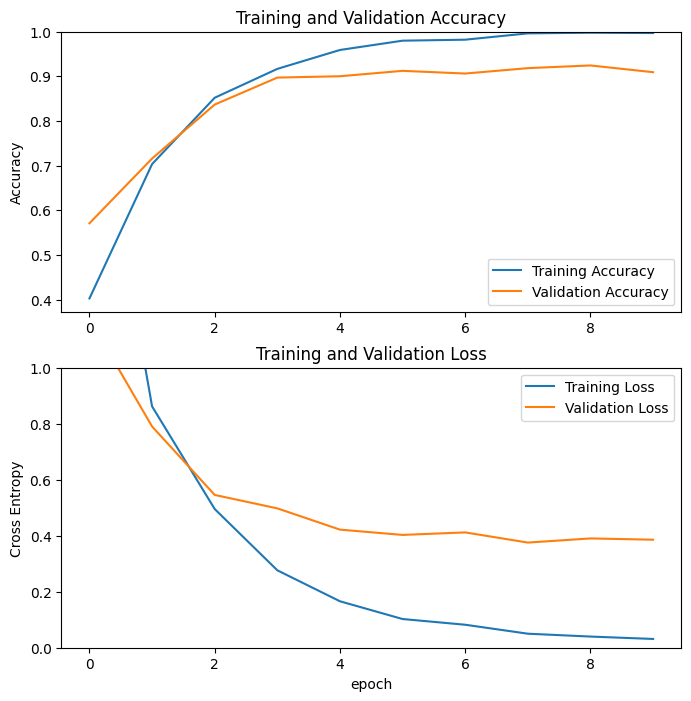

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [21]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [22]:
base_model.trainable = True
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [23]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 5, 32)          368672    
                                                                 
 dropout_1 (Dropout)         (None, 5, 5, 32)          0         
                                                                 
 global_average_pooling2d_1   (None, 32)               0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 10)                330       
                                                                 
Total params: 2,626,986
Trainable params: 2,230,442
No

In [25]:
history_fine = model.fit(train_generator,
                         steps_per_epoch=len(train_generator), 
                         epochs=5,
                         validation_data=val_generator,
                         validation_steps=len(val_generator))

Epoch 1/5
22/22 [==============================] - 73s 3s/step - loss: 0.7566 - accuracy: 0.7808 - val_loss: 0.4026 - val_accuracy: 0.9033
Epoch 2/5
22/22 [==============================] - 65s 3s/step - loss: 0.4890 - accuracy: 0.8403 - val_loss: 0.4194 - val_accuracy: 0.9003
Epoch 3/5
22/22 [==============================] - 65s 3s/step - loss: 0.3803 - accuracy: 0.8767 - val_loss: 0.4302 - val_accuracy: 0.9003
Epoch 4/5
22/22 [==============================] - 67s 3s/step - loss: 0.2589 - accuracy: 0.9108 - val_loss: 0.4360 - val_accuracy: 0.9003
Epoch 5/5
22/22 [==============================] - 65s 3s/step - loss: 0.2344 - accuracy: 0.9220 - val_loss: 0.4346 - val_accuracy: 0.9003


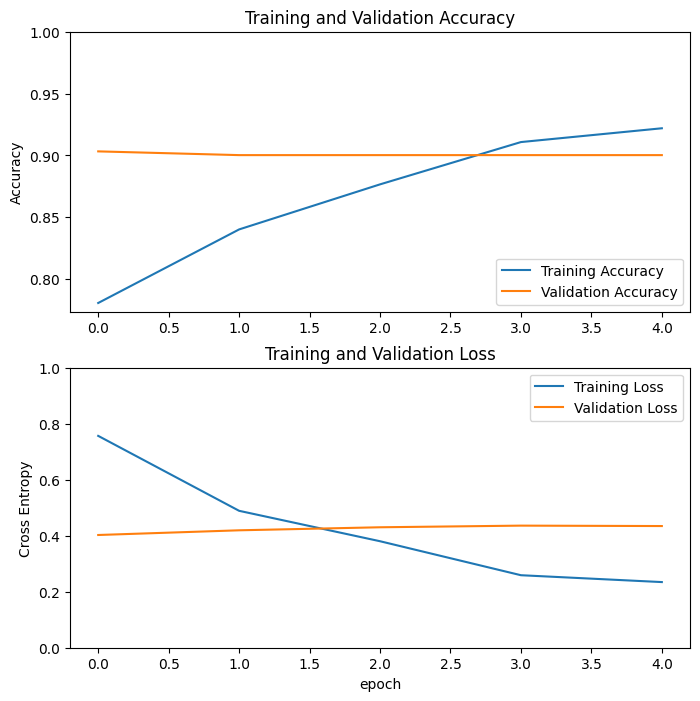

In [29]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [30]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('pois_mobilenet_v2_1.0_224.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Checkout\AppData\Local\Temp\tmps4znf3ye\assets


INFO:tensorflow:Assets written to: C:\Users\Checkout\AppData\Local\Temp\tmps4znf3ye\assets


In [28]:
print(tf.__version__)

2.9.0
